# Final Project - Part 1

### Libraries
Here we include all python-native and conda-bundled libraries

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

Helper functions for our project can be found in `scripts/helpers.py`. We refactor the common functions, e.g. function to read dataset file, in order to provide reusability and to reduce redudancy in our main notebook.

In [6]:
from scripts.helpers import read_raw_dataset, read_saved_dataframe, save_dataframe, debug_dataframe

### Datasets
We mainly use million songs datasets (msd), the msd provide two big datasets:
* msd_songs 
* msd_summary

<br>We read dataset using our predefined read_raw_dataset() function:

In [2]:
# load dataset
df_msd_songs   = read_raw_dataset("msd_songs")
df_msd_summary = read_raw_dataset("msd_summary")

Peek into the dataset using predefined debug_dataframe() function:

In [4]:
# debug dataframe msd_songs
debug_dataframe(df_msd_songs)

Dataset size:  (1000000, 11)
Dataset feature columns:  Index(['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year'],
      dtype='object')

Dataset Preview:


,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006


In [5]:
# debug dataframe msd_summary
debug_dataframe(df_msd_summary)

Dataset size:  (1000000, 53)
Dataset feature columns:  Index(['analysis_sample_rate', 'audio_md5', 'danceability', 'duration',
       'end_of_fade_in', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'key', 'key_confidence', 'loudness', 'mode',
       'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature',
       'time_signature_confidence', 'track_id', 'analyzer_version',
       'artist_7digitalid', 'artist_familiarity', 'artist_hotttnesss',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_mbid', 'artist_name', 'artist_playmeid', 'genre',
       'idx_artist_terms', 

,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid,idx_artist_mbtags,year
0,22050,aee9820911781c734e7694c5432990ca,0.0,252.05506,2.049,0.0,0,0,0,0,...,0,0,Monster Ballads X-Mas,633681,0.542899,SOQMMHC12AB0180CB8,Silent Night,7032331,0,2003
1,22050,ed222d07c83bac7689d52753610a513a,0.0,156.55138,0.258,0.0,0,0,0,0,...,0,0,Karkuteillä,145266,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,1514808,0,1995
2,22050,96c7104889a128fef84fa469d60e380c,0.0,138.97098,0.000,0.0,0,0,0,0,...,0,0,Butter,625706,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,6945353,0,2006


#### Datasets observation
* Dataset consist of exactly one million datapoints.
* Each datapoint (song) has 10 main attributes in msd_songs and 53 additional attributes in msd_summary. This makes all songs have 63 features.
* Our projects aim to observe trend of "popular songs", therefore we will mainly work with msd_songs since msd_summary mostly contains features that we may not really need.
* Main observations of the rest of the project will most likely deal with "song_hotttnesss", as this field relates to the popularity of a song. 
* column "track_id" is used as key (Primary Key) which is always unique and will be useful for join operation

## Data Preprocessing & Initial Features Analysis

From msd dataset, we get the information of exactly one million songs data with 63 features each (track_id, song_hotttnesss, artist_hotttnesss, year, artist_id, and so on). Now for the first part, we want to investigate the attributes that lead to song popularity. We define our dataset as pairs of:

$$ (x_n, y_n) $$
where:
$$ y_n := \text{n'th song hotttnesss} $$
$$ x_n := \text{n'th vector of D features} $$
$$ D = 62 $$

First set "track_id" as index for both dataframe

In [9]:
# Set index for both dataframe
df_msd_songs   = df_msd_songs.set_index(["track_id"])
df_msd_summary = df_msd_summary.set_index(["track_id"])

Then we need to merge both dataframe as single df_msd based on track_id

In [45]:
# perform inner join based on index (track_id)
df_msd = pd.concat([df_msd_songs, df_msd_summary], axis=1, join='inner')

Debug the result

In [12]:
debug_dataframe(df_msd)

Dataset size:  (1000000, 62)
Dataset feature columns:  Index(['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'analysis_sample_rate', 'audio_md5', 'danceability', 'duration',
       'end_of_fade_in', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'key', 'key_confidence', 'loudness', 'mode',
       'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature',
       'time_signature_confidence', 'analyzer_version', 'artist_7digitalid',
       'artist_familiarity', 'artist_hotttnesss', 'artist_id',
       'artist_lat

,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,...,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid,idx_artist_mbtags,year
track_id,,,,,,,,,,,,,,,,,,,,,
TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,...,0,0,Monster Ballads X-Mas,633681,0.542899,SOQMMHC12AB0180CB8,Silent Night,7032331,0,2003
TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,...,0,0,Karkuteillä,145266,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,1514808,0,1995
TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,...,0,0,Butter,625706,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,6945353,0,2006


Find and plot the correlation between features using heatmap

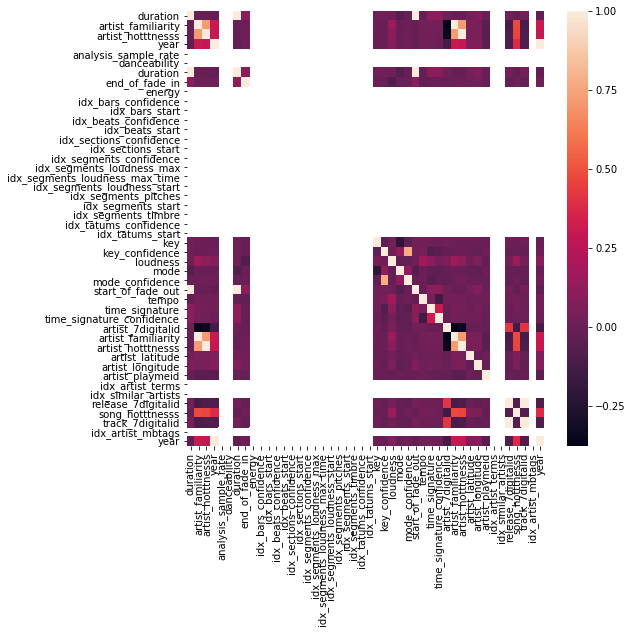

In [46]:
msd_corr = df_msd.corr()
fig, ax  = plt.subplots(figsize=(8,8))
sns.heatmap(msd_corr, 
            xticklabels=msd_corr.columns.values,
            yticklabels=msd_corr.columns.values, ax = ax)
plt.show()

#### Analyzing useless features
From above correlation chart, we can infer that some features do not give impact or relation to other attributes. Those features are: 
> ['analysis_sample_rate', 'audio_md5', 'danceability', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'idx_artist_terms',
       'idx_similar_artists', 'idx_artist_mbtags']

So we then analyze if either the value of these features are unique or not. If a feature is unique for the entire datapoints, we can ignore it and drop it to narrow our analysis.

In [42]:
# List of unrelated features
unrelated_features = ['analysis_sample_rate', 'audio_md5', 'danceability','energy', 'idx_bars_confidence', 
                      'idx_bars_start', 'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence', 
                      'idx_sections_start', 'idx_segments_confidence', 'idx_segments_loudness_max', 
                      'idx_segments_loudness_max_time', 'idx_segments_loudness_start', 'idx_segments_pitches', 
                      'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence', 'idx_tatums_start', 
                      'idx_artist_terms', 'idx_similar_artists', 'idx_artist_mbtags']

# define function to check unrelated features uniqueness 
def is_feature_unique(df, features):
    for feature in features:
        unique_value = df[feature].unique()
        if len(unique_value) == 1:
            print(feature + " is unique, only: " + str(unique_value[0]))

# check and print the unique features
is_feature_unique(df_msd, unrelated_features)

analysis_sample_rate is unique, only: 22050
danceability is unique, only: 0.0
energy is unique, only: 0.0
idx_bars_confidence is unique, only: 0
idx_bars_start is unique, only: 0
idx_beats_confidence is unique, only: 0
idx_beats_start is unique, only: 0
idx_sections_confidence is unique, only: 0
idx_sections_start is unique, only: 0
idx_segments_confidence is unique, only: 0
idx_segments_loudness_max is unique, only: 0
idx_segments_loudness_max_time is unique, only: 0
idx_segments_loudness_start is unique, only: 0
idx_segments_pitches is unique, only: 0
idx_segments_start is unique, only: 0
idx_segments_timbre is unique, only: 0
idx_tatums_confidence is unique, only: 0
idx_tatums_start is unique, only: 0
idx_artist_terms is unique, only: 0
idx_similar_artists is unique, only: 0
idx_artist_mbtags is unique, only: 0


#### Dropping features
From above results, we drop these features:
* 'analysis_sample_rate' 
* 'danceability'
* 'energy'
* 'idx_bars_confidence' 
* 'idx_bars_start'
* 'idx_beats_confidence'
* 'idx_beats_start'
* 'idx_sections_confidence'
* 'idx_sections_start'
* 'idx_segments_confidence'
* 'idx_segments_loudness_max'
* 'idx_segments_loudness_max_time'
* 'idx_segments_loudness_start'
* 'idx_segments_pitches'
* 'idx_segments_start'
* 'idx_segments_timbre'
* 'idx_tatums_confidence'
* 'idx_tatums_start'
* 'idx_artist_terms'
* 'idx_similar_artists'
* 'idx_artist_mbtags'

*Dropping features md5*
<br>From the [dataset description](https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description), we decide to drop feature md5:
* 'audio_md5' | string | audio hash code : DROP (useless)

Thus, we drop all unrelated_features

In [47]:
df_msd = df_msd.drop(unrelated_features, axis=1)

Replot the correlation heatmap

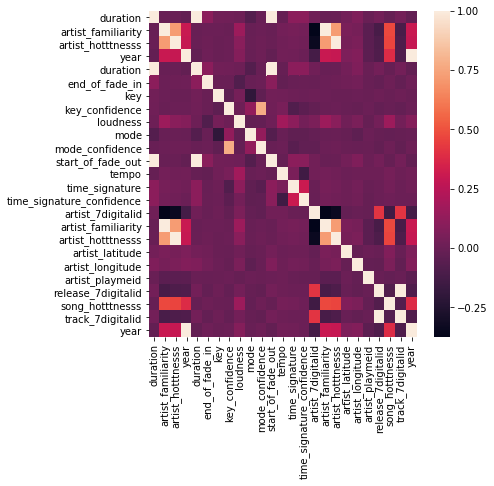

In [48]:
msd_corr = df_msd.corr()
fig, ax  = plt.subplots(figsize=(6,6))
sns.heatmap(msd_corr, 
            xticklabels=msd_corr.columns.values,
            yticklabels=msd_corr.columns.values, ax = ax)
plt.show()

See what's left on msd dataframe

In [49]:
debug_dataframe(df_msd)

Dataset size:  (1000000, 40)
Dataset feature columns:  Index(['title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'duration', 'end_of_fade_in', 'key', 'key_confidence',
       'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo',
       'time_signature', 'time_signature_confidence', 'analyzer_version',
       'artist_7digitalid', 'artist_familiarity', 'artist_hotttnesss',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_mbid', 'artist_name', 'artist_playmeid', 'genre', 'release',
       'release_7digitalid', 'song_hotttnesss', 'song_id', 'title',
       'track_7digitalid', 'year'],
      dtype='object')

Dataset Preview:


,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,...,artist_name,artist_playmeid,genre,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid,year
track_id,,,,,,,,,,,,,,,,,,,,,
TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,...,Faster Pussy cat,44895,,Monster Ballads X-Mas,633681,0.542899,SOQMMHC12AB0180CB8,Silent Night,7032331,2003
TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,...,Karkkiautomaatti,-1,,Karkuteillä,145266,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan,1514808,1995
TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,...,Hudson Mohawke,-1,,Butter,625706,0.617871,SOGTUKN12AB017F4F1,No One Could Ever,6945353,2006


# Solution to our first research questions¶

## Q1.1 What is the characteristic/metrics of popular songs?
In this part, we want to find the features which lead to the popularity of the song. In order to find the important feature, we propose to use random forest to predict whether this song is popular/unpopular. Once we get high accurcay by random forest, we observe the attribute **feature\_importances** to see which feature matters the most. Lastly, we combine our common sense to see whether the result got from random forest is reasonable.

## Q1.2 What are the challenges that music industry faces? 
#### Perhaps we need to find the similarities of recent popular songs

## Q1.3 Can we analyze and predict the trend in music industry from years to years?
#### I think we can only conclude which genre is popular in specific year, and we try to find the story behind it. Besides, we can find the duration of popular genre and perhaps it could help us know how long this popular genre would proceed